# March Madness Logistic Regression

We want to implement a simple logistic regression model to predict winners of NCAA basketball games based on seed differences between the teams playing.  This follows https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset/notebook.

We first import the required packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.utils import shuffle

%matplotlib inline

## Load in the data

Let's load the data in and look at the dataframes.  We only need the Season, WTeamID, and LTeamID columns for the results file.

In [2]:
game_results = pd.read_csv('Data/NCAATourneyCompactResults.csv')[['Season','WTeamID','WScore','LTeamID','LScore']]
team_seeds = pd.read_csv('Data/NCAATourneySeeds.csv')

game_results.head()

,Season,WTeamID,WScore,LTeamID,LScore
0,1985,1116,63,1234,54
1,1985,1120,59,1345,58
2,1985,1207,68,1250,43
3,1985,1229,58,1425,55
4,1985,1242,49,1325,38


In [3]:
team_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


We next need to convert the seed to a numeric value.

In [4]:
seed_to_int = lambda x: int(''.join([s for s in x if not s.isalpha()]))
team_seeds['Seed'] = team_seeds['Seed'].apply(seed_to_int)

team_seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


Now let's merge these dataframes and create a column with the seed difference for each game.

In [5]:
win_seeds = team_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
loss_seeds = team_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

merge_win = pd.merge(left=game_results,right=win_seeds,how='left',on=['Season','WTeamID'])
df = pd.merge(left=merge_win,right=loss_seeds,on=['Season','LTeamID'])
df['SeedDelta'] = df['WSeed'] - df['LSeed']

df.head()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDelta
0,1985,1116,63,1234,54,9,8,1
1,1985,1120,59,1345,58,11,6,5
2,1985,1207,68,1250,43,1,16,-15
3,1985,1229,58,1425,55,9,8,1
4,1985,1242,49,1325,38,3,14,-11


From here we can gather for each game the seed difference and the outcome.

In [6]:
wins = pd.DataFrame()
wins['SeedDelta'] = df['SeedDelta']
wins['Result'] = 1

loss = pd.DataFrame()
loss['SeedDelta'] = -df['SeedDelta']
loss['Result'] = 0

predictions = pd.concat([wins,loss])
predictions.head()

,SeedDelta,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


Let's visualize our data so far.

Text(0,0.5,'Result (Win = 1)')

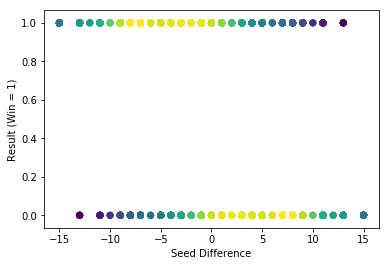

In [7]:
#Use kernel density estimate
from scipy.stats import gaussian_kde
xy = np.vstack([predictions.values.T[0],predictions.values.T[1]])
de = gaussian_kde(xy)(xy)

#plot densities
plt.scatter(predictions['SeedDelta'],predictions['Result'],c=de)
plt.xlabel('Seed Difference')
plt.ylabel('Result (Win = 1)')

Text(0,0.5,'Mean Result')

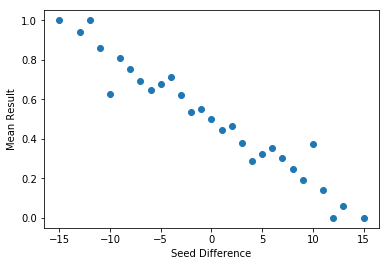

In [8]:
#get mean results at each seed difference
delta_vals = np.unique(predictions['SeedDelta'].values)
mean_result = []
for val in delta_vals:
    mean_result.append(np.mean(predictions[predictions['SeedDelta']==val]['Result'].values))

#plot mean results
plt.plot(delta_vals,mean_result,'o')
plt.xlabel('Seed Difference')
plt.ylabel('Mean Result')

## Train our model

Now that we have the data read in, we can try to fit it to a logistic regression model.  As this is only based on a single feature and has a lot of data, overfitting is not a concern.  We take a large C to mostly ignore regularization.

Text(0,0.5,'Mean Result')

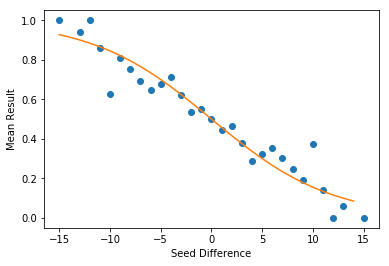

In [9]:
concat_df = pd.concat([df,df])

#split up into features and ground truth for games before 2014
x_preds = predictions['SeedDelta'].values.reshape(-1,1)
y_preds = predictions['Result'].values

x_train = x_preds[concat_df['Season']<2014]
y_train = y_preds[concat_df['Season']<2014]

x_train,y_train = shuffle(x_train,y_train)

#create classifier and train
logistic_reg = LogisticRegression(C=10000) #C is inverse of regularization strength
logistic_reg.fit(x_train,y_train)

#plot resulting probability
xvals = np.arange(-15,15).reshape(-1,1)
p=logistic_reg.predict_proba(xvals)[:,1]

plt.plot(delta_vals,mean_result,'o')
plt.plot(xvals,p)

plt.xlabel('Seed Difference')
plt.ylabel('Mean Result')

## Test our model on the training data.

We now want to test this model to see how it performs.  Note that we have not held out any validation or testing data explicitly, so this is almost certainly an overestimate.

We'll first check out how many winning teams are correctly predicted to win from this model.

In [10]:
#create test data of games played from 2014 on
x_test = x_preds[concat_df['Season']>=2014]
y_test = y_preds[concat_df['Season']>=2014]

logreg_preds = logistic_reg.predict_proba(x_test)
logreg_wins = logreg_preds[:,1]>0.5
np.mean(logreg_wins==y_test)

0.70895522388059706

Ok, not great but probably about as expected.  Let's look at the log loss (ie the cross entropy).  

In [11]:
gt = np.zeros_like(logreg_preds)
gt[:,1]=y_test
gt[:,0] = 1 - gt[:,1]
logloss = sklearn.metrics.log_loss(gt,logreg_preds)
print(logloss)

0.571248075567
